### Abstract 

Uropathogenic *Escherichia coli* (UPEC) is the major causative agent of uncomplicated urinary tract infections (UTIs). A common virulence genotype of UPEC strains responsible for UTIs is yet to be defined, due to the large variation of virulence factors observed in UPEC strains. We hypothesized that studying UPEC functional responses in patients might reveal universal UPEC features that enable pathogenesis. Here we identify a transcriptional program shared by genetically diverse UPEC strains isolated from 14 patients during uncomplicated UTIs. Strikingly, this in vivo gene expression program is marked by upregulation of translational machinery, providing a mechanism for the rapid growth within the host. Our analysis indicates that switching to a more specialized catabolism and scavenging lifestyle in the host allows for the increased translational output. Our study identifies a common transcriptional program underlying UTIs and illuminates the molecular underpinnings that likely facilitate the fast growth rate of UPEC in infected patients.


In [1]:
# Settings for the whole paper

# Imports
import pandas as pd
import sys
import datetime as dt
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from operator import itemgetter
import os
import pandas as pd
from pathlib import Path
import scipy
from scipy import stats
import seaborn as sns;sns.set_style("white")
import sys

today = dt.datetime.today().strftime("%Y-%m-%d")

import utilities as ut

%matplotlib inline

#--------------------------------------------------------------------------------------------------------
# Paths and configs
config_dict = ut.process_config('config')
figs = Path('figures')
results = Path('results')

# Ortholog matrix
orth_matrix = pd.read_csv(config_dict['data']['ortholog_table'], index_col=0)

# Raw Counts
counts_dir = config_dict['data']['counts']
raw_counts = pd.read_csv(config_dict['data']['raw_core_counts'], index_col=0)

# GFF Files
gff_dir = config_dict['data']['gff_dir']

# TPMs
tpms_dict = ut.normalize_counts_to_tpm(counts_dir, gff_dir, results)
tpms = pd.DataFrame(tpms_dict)
tpms.columns = [c.split("_counts")[0] for c in tpms.columns]

# Normalized TPMs
norm_counts = tpms.apply(ut.invnorm) # Throws a warning

# Normalized Core counts
core_counts = ut.get_tpms_for_prokkas(orth_matrix, tpms)
norm_core = core_counts.apply(ut.invnorm)

# DESeq2 Normalized Counts
deseq2_counts = pd.read_csv(config_dict["data"]["deseq2_norm_counts_file"], index_col=0)

# Strain Info
strain_info = pd.read_csv(config_dict['data']['strain_info'], index_col=0)
strains = config_dict["strains"]["all"].split()
b1_strains = config_dict['strains']['b1_strains'].split()
b2_strains = config_dict['strains']['b2_strains'].split()



#--------------------------------------------------------------------------------------------------------
# For Figure 1

# Virulence genes
info_file = Path(config_dict["data"]["virulence_genes_info"])
vg_info = pd.read_csv(info_file, index_col=0, header=None, names=["gene_name", "function"])
pa_matrix = pd.read_csv(config_dict['data']['virulence_pa_file'], index_col=0)
pa_matrix.index = [i.split("|")[0] for i in pa_matrix.index]
identity_matrix = pd.read_csv(config_dict["data"]["virulence_identity"], index_col=0)
identity_matrix.index = [i.split("|")[0] for i in identity_matrix.index]
vg_info2 = vg_info.merge(identity_matrix, left_index=True, right_index=True)
new_name = ["{} ({}%)".format(gene, str(ident)) for gene, ident in zip(vg_info2.gene_name, vg_info2.identity)]
#vg_info["gene_name"] = new_name # Comment this out if don't want % identity in the final legend

#--------------------------------------------------------------------------------------------------------
# For Figure 3
# Results of the differential expression analysis and pathway analysis
de_results = pd.read_csv(config_dict["data"]["all_genes_file"], index_col=0)
de_sign = de_results[(abs(de_results.log2FoldChange) > 2) & (de_results.padj < 0.05)]
go_analysis = (pd.read_csv(config_dict["data"]["go_file"], index_col=0)
              .sort_values("Annotated", ascending=False)
              .set_index("GO.ID"))
# Only look at GO grous with > 10 terms and p-value < 0.05
go_analysis = go_analysis[(go_analysis.Annotated >=10) & (go_analysis.elimFisher < 0.05)]


def get_subset_genes(df, key, col_return="log2FoldChange",column_name="Function"):
    keep = []
    if not type(key) == str:
        return df[df[column_name].isin(key)][col_return]
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]


def get_go(go_analysis_df, GO_ID): # list of GO.ID numbers
    genes = []
    for go in GO_ID:
        genes += go_analysis_df.loc[go]["DEGenesInTerm"].split(',')
    return set(genes)

#--------------------------------------------------------------------------------------------------------
# For Figure 4 & 5
crp_genes = pd.read_csv(config_dict["data"]["crp_genes"], header=None)[0].values #425
alingment_stats = pd.read_csv(config_dict['data']['alingment_stats_file'], index_col=0)
alingment_stats.index = [c.replace(" | ", "_") for c in alingment_stats.index]
mouse_counts  = pd.read_csv(config_dict['data']['mouse_counts_file'], index_col=0)
hm43_alingment_stats = pd.read_csv(config_dict['data']['hm43_alingment_stats_file'], index_col=0)
growth_data = pd.read_csv(config_dict['data']['hm43_growth_file']).dropna()

#--------------------------------------------------------------------------------------------------------
# For Figure 6

def gene_name_to_protein_name(name):
    return name[:3].capitalize() + name[3:].capitalize()

gsea_analysis = pd.read_csv(config_dict['data']['final_gsea_analysis'], index_col=0)
gsea_analysis['Function'] = [i.split("_")[1].capitalize() for i in gsea_analysis.index]
gsea_analysis.index = [gene_name_to_protein_name(i.split("_")[0]) for i in gsea_analysis.index]
gsea_analysis["Expression (higher in)"] = ["Patients"  if n < 0 else 'Urine' for n in gsea_analysis.NES]
gsea_analysis_pretty = (gsea_analysis[['Function', "Expression (higher in)", 'Regulon Size', 
                                       'Matched Size', "NES", 'FDR']].sort_values('NES', ascending=False)) 
           
#--------------------------------------------------------------------------------------------------------
# Colors 
col1 = "#f34236"
col2 = "#d6c571"
col3 = "#88bc67"
col4 = "#2e8174"
col5 = "#143969"
clrs = [col1, col2, col3, col4, col5]
my_cmap = LinearSegmentedColormap.from_list('custom blue', [col5, col4, col2, col1], N=256)

ur = "URINE"
uti = "PATIENT"
join = " | "


/anaconda/envs/biology/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/anaconda/envs/biology/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


# Figure 1

### Clinical UPEC isolates carry a highly variable set of virulence factors.  
**(A)** Clinical UPEC isolates were examined for presence of 40 virulence factors. Virulence factors were identified based on homology using BLAST searches (≥80% identity, ≥90% coverage, average % identity indicated next to gene name). The heatmap shows presence (black) or absence (white) of virulence factors across 14 UPEC strains. Hierarchical clustering based on presence/absence of virulence factors shows separate clustering of B1 isolates.

**(B)** Normalized gene expression of the 40 virulence factors in UPEC strains during in vitro urine culture. 

**(C)** Normalized gene expression of the 40 virulence factors in UPEC strains in patients. 

<Figure size 432x288 with 0 Axes>

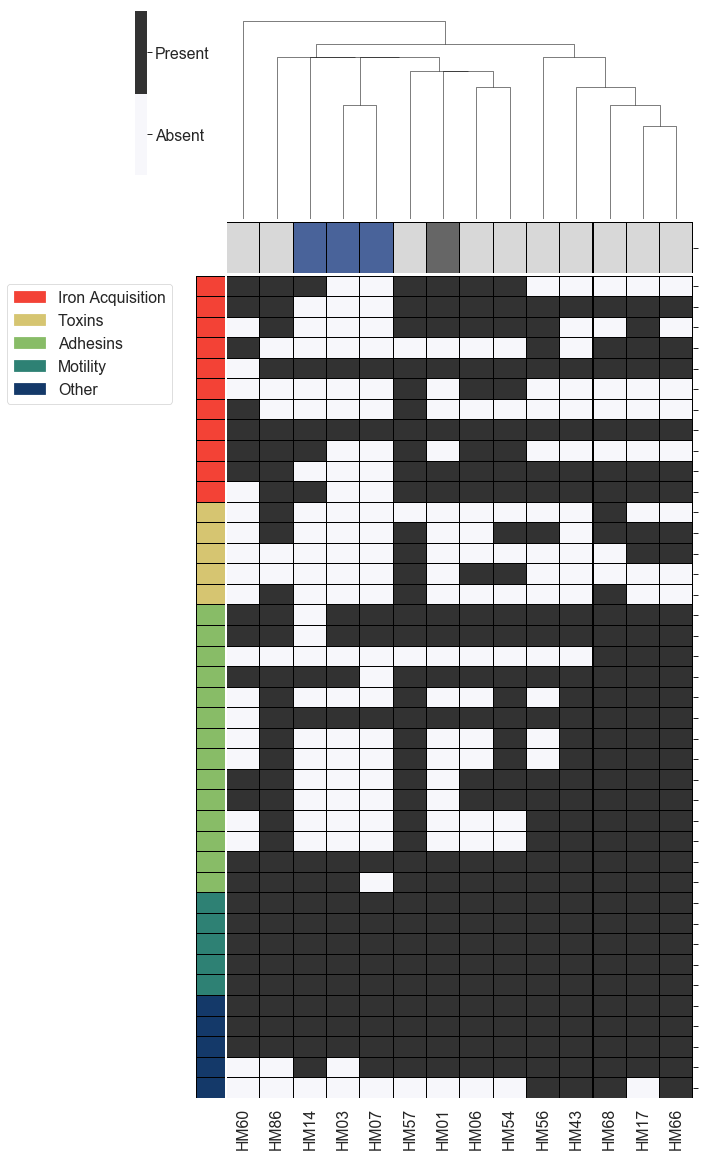

In [16]:
# Getting counts for virulence genes
virulence_cnts = ut.get_tpms_for_prokkas(pa_matrix, norm_counts)
virulence_cnts = vg_info.merge(virulence_cnts, left_index=True, right_index=True).set_index("gene_name")

# Adding gene name, setting it as index
pa_mat = (vg_info.merge(pa_matrix, left_index=True, right_index=True)
          .set_index("gene_name")
          .fillna(0)
         .replace("PROKKA*", 1, regex=True))
pa_mat.index.name=""


# Visualization

# Defining functional categories and phylogroups
function = pa_mat.pop("function")
phylogroup = (strain_info[["STRAIN", "PRED_PHYLO"]]
             .drop_duplicates()
             .set_index("STRAIN"))

# Hierarchical clustering based on presence/absence of virulence factors
strain_cluster = scipy.cluster.hierarchy.linkage(pa_mat.T) # distances between strains


# Mapping colors
num_colors = len(function.unique()) # there's 5 colors and 5 functional catergories
function_to_color = dict(zip(function.unique(), clrs))
phylogroup_to_color = dict(zip(strain_info.PRED_PHYLO.unique(), ["#666666", "#49639a", "#d8d8d8"]))
row_colors = function.map(function_to_color)
row_colors.name =""
col_colors = phylogroup.PRED_PHYLO.map(phylogroup_to_color)
col_colors.name=""
cmap = ListedColormap(["#f7f7fb", "#323232"])  # Black and almost white

sns.set_context("paper", font_scale=1.8) 
fig = plt.figure()
# Drawing the heatmap
g = sns.clustermap(pa_mat, row_cluster=False, col_linkage=strain_cluster, 
                   row_colors=row_colors, col_colors=col_colors, cmap=cmap,
                   linewidth = 0.05, linecolor="black",
                   figsize=(10,20));

# Adjusting the x and y labels
# Since this will be left panel of multipanel figures, do not want y labels
#la = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 14);
la = g.ax_heatmap.set_yticklabels("");

# Creating Legend
function_legend = [mpl.patches.Patch(color=c, label=l) for l,c in function_to_color.items()]
pg_legend = [mpl.patches.Patch(color=c, label=l) for l,c in phylogroup_to_color.items()]

# Displaying function legend
l2 = g.ax_heatmap.legend(handles=function_legend, bbox_to_anchor=(-0.1,1), frameon=True)

# Make a categorical colorbar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_ticks([ 0.25, 0.75])
colorbar.set_ticklabels([ 'Absent', 'Present'])
colorbar.solids.set_edgecolor("face")

# Save figure
g.savefig(figs/'Figure_1a.png', dpi=150, bbox_inches = "tight")

In [17]:
# Getting URINE counts
ur_cnts = virulence_cnts[[c for c in virulence_cnts.columns if "UR" in c ]]
ur_cnts.columns = [c.split("_")[0] for c in ur_cnts.columns]
ur_cnts = ur_cnts[pa_mat.columns]
ur_cnts.index.name=""
# Getting UTI counts
uti_cnts = virulence_cnts[ [c for c in virulence_cnts.columns if "UTI" in c ]]
uti_cnts.columns = [c.split("_")[0] for c in uti_cnts.columns]
uti_cnts = uti_cnts[pa_mat.columns] #for strain_cluster to work columns need to be in same order in all 3 dfs
uti_cnts.index.name=""

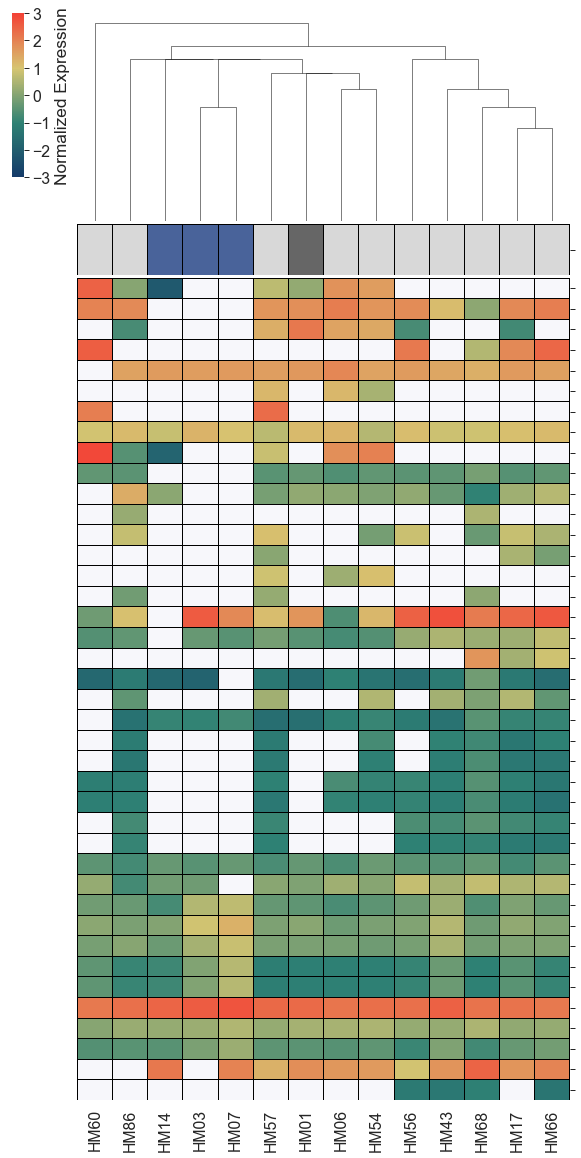

In [18]:
# URINE
cmap = my_cmap # From settings
cmap.set_bad(color='#f7f7fb')

#Drawind the heatmap
ur_h = sns.clustermap(ur_cnts, row_cluster=False, col_linkage=strain_cluster, 
                      col_colors=col_colors,cmap = cmap, 
                      linewidth = 0.05, linecolor='black',
                      figsize = (10,20), vmin = -3, vmax = 3,
                      cbar_kws={"label":"Normalized Expression", });

# Adjusting the x and y labels
#la = ur_h.ax_heatmap.set_yticklabels(ur_h.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 14);
# Middle panel, don't want any labels
la = ur_h.ax_heatmap.set_yticklabels("");

# Saving file
ur_h.savefig(figs/"Figure_1b.png", dpi=150, bbox_inches = "tight")

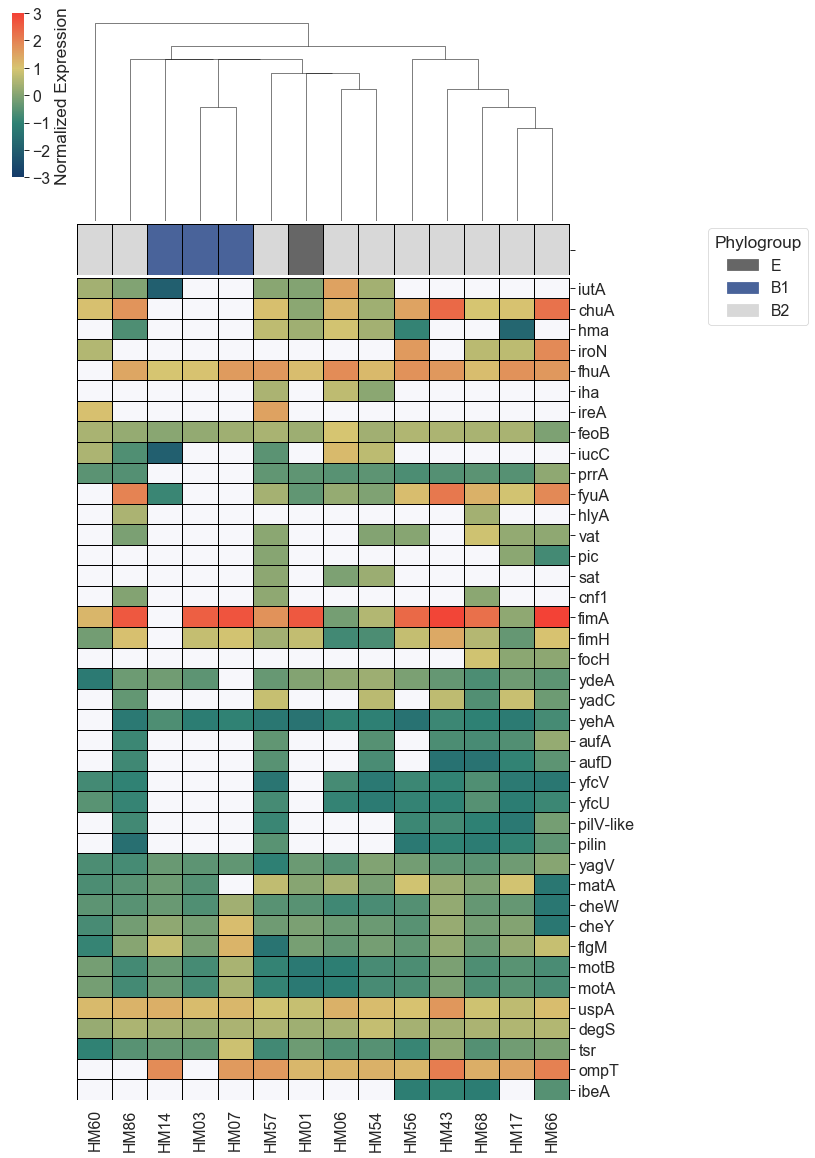

In [19]:
# PATIENTS
# Drawing the heatmap
col_colors.name = ''
uti_h = sns.clustermap(uti_cnts, row_cluster=False, col_linkage=strain_cluster, 
                       col_colors=col_colors,cmap = cmap, 
                       linewidth = 0.05, linecolor = 'black',
                       figsize = (10,20), vmin = -3, vmax = 3, 
                       cbar_kws={"label":"Normalized Expression",});

# Adjusting the x and y labels
la = uti_h.ax_heatmap.set_yticklabels(uti_h.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 16);
l2 = uti_h.ax_heatmap.legend(handles=pg_legend, bbox_to_anchor=(1.5,1.07))
l2.set_title("Phylogroup")
uti_h.savefig(figs/"Figure_1c.png", dpi=150, bbox_inches = "tight")

# Figure 2

### Core genome expression in patients is highly correlated. 
**(A)** Correlations among in vitro and patient samples measured by Pearson correlation coefficient of normalized gene expression plotted according to hierarchical clustering of samples. 

**(B)** Pearson correlation coefficient among all samples cultured in vitro (URINE | URINE, median = 0.92), among all samples isolated from patients (PATIENT | PATIENT, median = 0.91), between samples cultured in urine and samples isolated from patients (URINE | PATIENT, median = 0.73), and between matching urine/patient samples (ex. HM14 | URINE vs HM14 | PATIENT), (URINE | PATIENT:matched, median = 0.74). 

**(C)** Principal component analysis of normalized gene expression of 14 clinical isolates in patients and in vitro urine cultures shows distinct clustering of in vitro and patient isolates. 


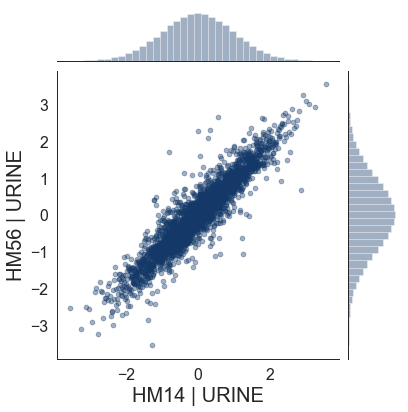

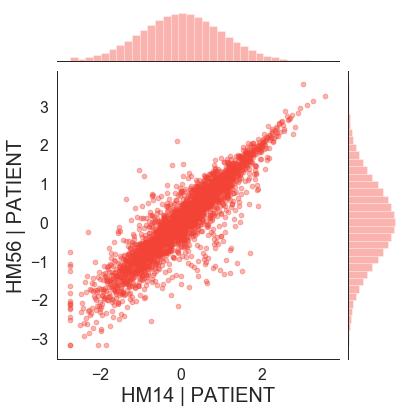

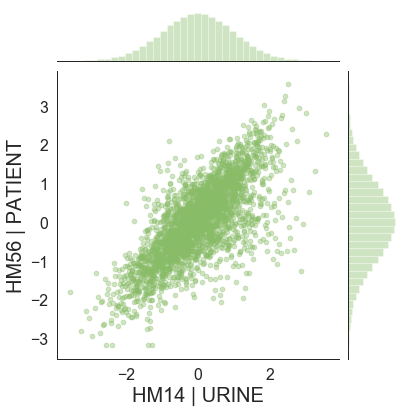

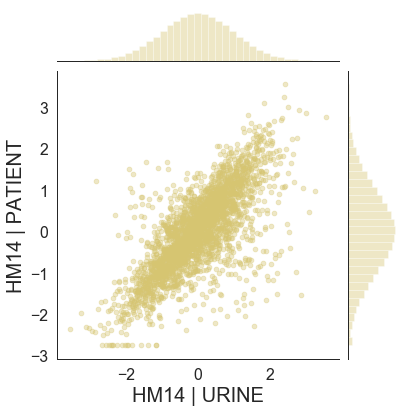

In [20]:
# Example correlation using HM14 and HM56
conditions = [("HM14_UR", "HM56_UR"), # UR vs. UR
              ("HM14_UTI", "HM56_UTI"), # UTI vs. UTI
              ("HM14_UR", "HM56_UTI"), # UR vs. unmatched UTI
              ("HM14_UR", "HM14_UTI")] # UR vs. matched UTI
clrs = [col5, col1, col3, col2, col4]
for i, cond in enumerate(conditions):
    s = sns.jointplot(norm_core[cond[0]], norm_core[cond[1]], color=clrs[i], alpha=0.4);
    yl = ut.sample_label_from_sample_name(cond[1])
    xl = ut.sample_label_from_sample_name(cond[0])
    s.set_axis_labels(xl, yl, fontsize=20)

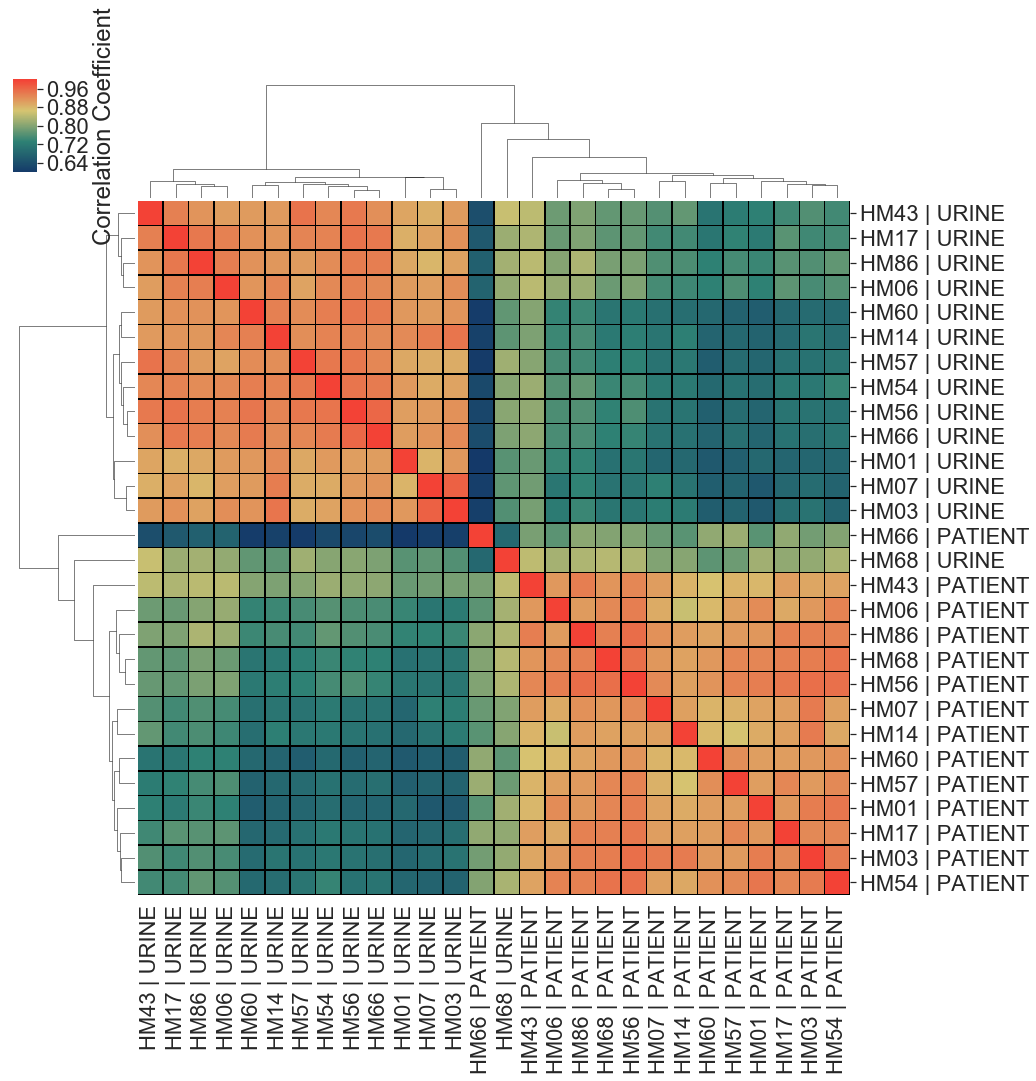

In [21]:
correlation_df = norm_core.corr()
correlation_df.columns = [ut.sample_label_from_sample_name(c) for c in correlation_df.columns]
correlation_df.index = [ut.sample_label_from_sample_name(i) for i in correlation_df.index]

sns.set_style("white")
sns.set_context("notebook", font_scale=2.0)
g = sns.clustermap(correlation_df, cmap=my_cmap, linewidths=0.5, linecolor='black',figsize=(15,15),vmin=0.6, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
g.savefig(figs/"Figure_2a.png", dpi = 150, bbox_inches="tight")

In [22]:
def get_correlations_values(dataCorr):
    dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool)).stack().reset_index()
    return dataCorr[0].values

correlation_df = norm_core.corr()
urine_cols = sorted([c for c in tpms.columns if 'UR' in c])
uti_cols = sorted([c for c in tpms.columns if 'UTI' in c])

urine_corr_df = correlation_df.loc[urine_cols, urine_cols]
uti_corr_df = correlation_df.loc[uti_cols, uti_cols]

urine_corr = get_correlations_values(urine_corr_df)
uti_corr = get_correlations_values(uti_corr_df)

urine_uti_corr = correlation_df.loc[urine_cols, uti_cols].stack().values

matching_vals = [correlation_df.loc[ur, uti] for ur, uti in zip(urine_cols, uti_cols)]


all_corrs = [pd.DataFrame({'sample': ['URINE | URINE']* len(urine_corr), 'pearsonr': urine_corr}),
             pd.DataFrame({'sample': ["PATIENT | PATIENT"]* len(uti_corr), 'pearsonr': uti_corr}),
             pd.DataFrame({'sample': ['URINE | PATIENT']* len(urine_uti_corr), 'pearsonr': urine_uti_corr}),
             pd.DataFrame({'sample': ['URINE | PATIENT:matched']* len(matching_vals), 'pearsonr': matching_vals})]

data = pd.concat(all_corrs)

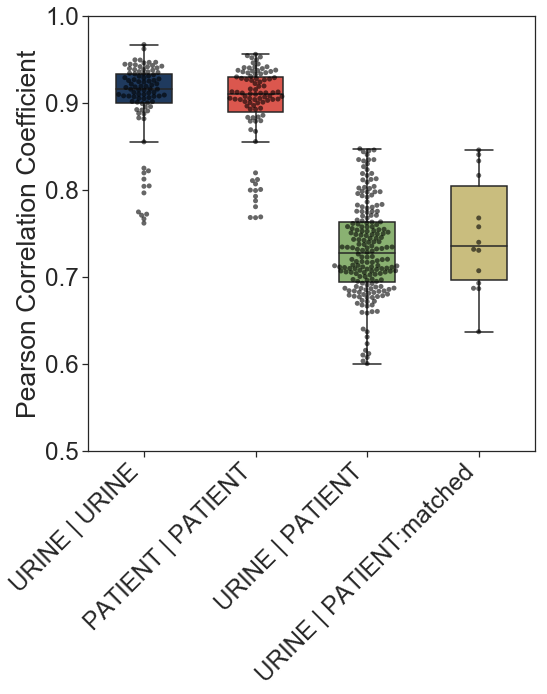

In [23]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=2.2)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x = "sample", y = "pearsonr", data = data, palette=[col5, col1, col3, col2, col1], 
                 width=.5, showfliers=False)
ax = sns.swarmplot(x = "sample", y = "pearsonr", data = data, color = 'black', alpha = 0.6)
ax.set_xlabel("")
ax.set_ylabel("Pearson Correlation Coefficient", )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", )
plt.ylim(0.5, 1)
plt.savefig(figs/"Figure_2b.png", dpi = 150, bbox_inches="tight")

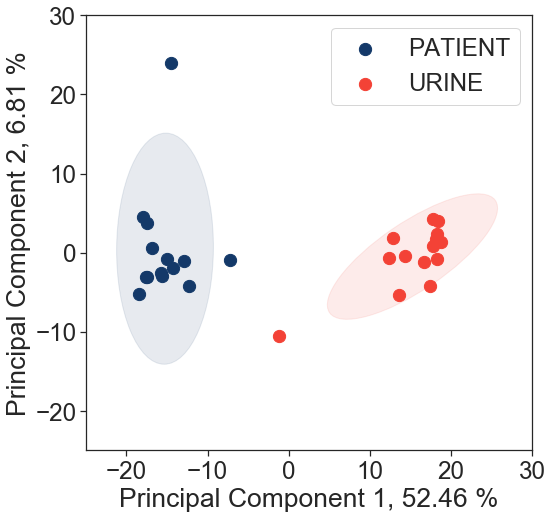

In [24]:
norm_core_ed = norm_core.copy()
norm_core_ed.columns = [ut.sample_label_from_sample_name(c) for c in norm_core_ed.columns]
norm_core_ed.head()
pDf, pc1, pc2 = ut.find_pc1_pc2(norm_core_ed, strain_info)
f = ut.plotPCA(pDf, pc1, pc2, "MEDIA", col=[col5, col1], nameby="", el=True)
ax = f.gca()
ax.set_xlim((-25, 30))
ax.set_ylim((-25, 30))
f.savefig(figs/"Figure_2c.png", dpi = 150, bbox_inches="tight")

# Figure 3

### Patient-associated transcriptional signature is consistent with rapid bacterial growth. 

**(A)** The DESeq2 R package was used to compare in vitro urine cultures gene expression to that in patients. Each UPEC strain was considered an independent replicate (n = 14). Genes were considered up-regulated (down-regulated) if log2 fold change in expression was higher (lower) than 2 (vertical lines), and P value < 0.05 (horizontal line). Using these cutoffs, we identified 149 upregulated genes, and 343 downregulated genes. GO/pathway analysis showed that large proportion of these genes belonged to one of the 4 functional categories (see legend) 

**(B)** Mean normalized expression for genes belonging to differentially expressed functional categories/pathways. Number of up(down)-regulated genes belonging to each category is indicated next to the category name. 

In [2]:
# UP
col_return = ["log2FoldChange", "Name", "Function"]
rprotein = get_subset_genes(de_sign, "ribosomal subunit protein", col_return)
rRNA = get_subset_genes(de_sign, "rRNA", col_return)
rna_helicase = get_subset_genes(de_sign, "helicase",col_return)
tRNA_genes = get_go(go_analysis, ["GO:0006400", "GO:0008033"])
tRNA =get_subset_genes(de_sign, tRNA_genes, col_return, "Name")
purine = get_subset_genes(de_sign[de_sign.log2FoldChange >0], "urine", col_return + ["Pathways"] , "Pathways")
pyrimidine = get_subset_genes(de_sign[de_sign.log2FoldChange >0], "yrimidine", col_return, "Pathways")
flagella_genes = "flgB,flgC,flgD,flgE,flgG".split(',')
flagella = get_subset_genes(de_sign, flagella_genes, col_return, "Name")
aa_t = ["b1605", "b2678", "b2679", "b2796", "b2845",
        "b3184", "b3539", "b3795", "b3827", "b4156"]
aa_trans = de_sign.loc[aa_t][col_return]

up_subsets={"Ribosomal Proteins":rprotein,
             "rRNA Modification":rRNA,
            "RNA Helicases": rna_helicase,
           "tRNA Processing/Modification": tRNA,
           "Purine Metabolism":purine,
           "Pyrimidine Metabolism":pyrimidine,
            "Amino Acid Transporters": aa_trans,
            "Flagella": flagella }

In [26]:
# DOWN
arginine = get_subset_genes(de_sign, "Arginine", col_return, "Pathways")
val = get_subset_genes(de_sign, "Valine", col_return, "Pathways")
maltose = get_subset_genes(de_sign, "maltose", col_return)
cys = get_subset_genes(de_sign, "Cysteine", col_return, "Pathways" )
glycine = get_subset_genes(de_sign, "Glycine", col_return, "Pathways" )
galactose = get_subset_genes(de_sign, "Galactose", col_return, "Pathways" )
starch =  get_subset_genes(de_sign, "Starch", col_return, "Pathways" )
carb_transport_genes = get_go(go_analysis, ['GO:0034219'])
carb_transport = get_subset_genes(de_sign, carb_transport_genes, col_return, "Name")
biofilm_genes = get_go(go_analysis, ['GO:0042710'])
biofilm = get_subset_genes(de_sign[de_sign.log2FoldChange<0], biofilm_genes, col_return, 'Name')
carb_transport_up = carb_transport[carb_transport.log2FoldChange > 0] # make a sepearte figure for this
carb_transport_down = carb_transport[carb_transport.log2FoldChange < 0]

down_subsets = {"Arginine Metabolism":arginine,
               "Val/Leu/Ileu Metabolism":val,
               "Cys/Met Metabolism": cys,
               "Gly/Ser/Thr Metabolism": glycine,
               "Maltose Metabolism": maltose,
               "Galactose Metabolism": galactose,
               "Starch/Sucrose Metabolism": starch,
                "Sugar Transporters":carb_transport_down,
               "Biofilm/Curli": biofilm,}

Down:  344
Up:  150


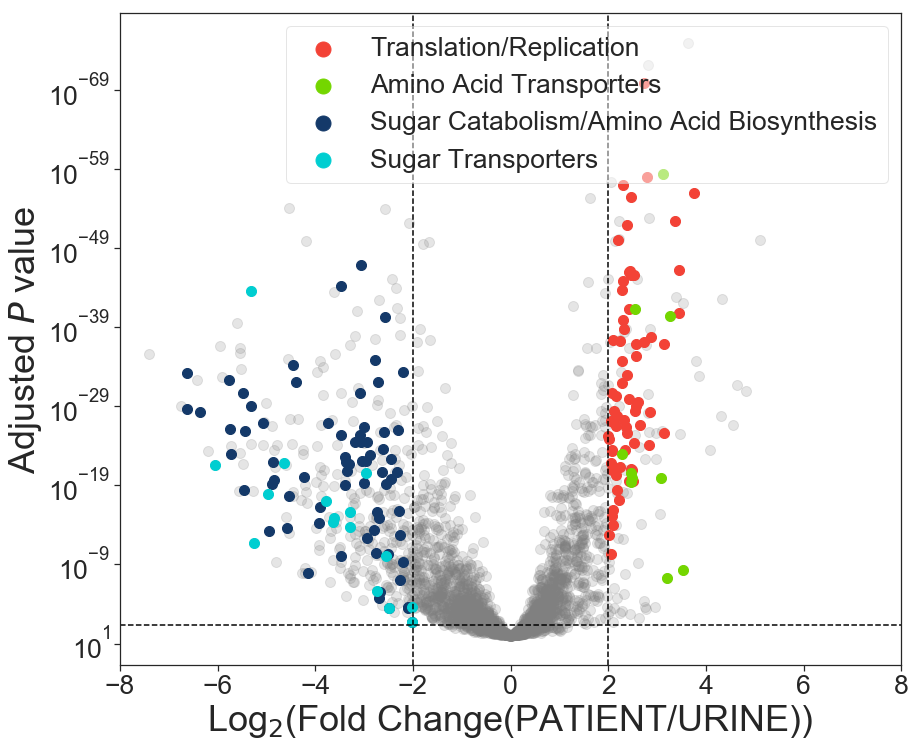

In [28]:
# Drawing the volcano plot

translation_replication_genes = [d.index for d in [rprotein, rRNA, rna_helicase, tRNA, purine, pyrimidine]]
translation_replication_genes = set([g for r in translation_replication_genes for g in r])
aa_tt_genes = aa_trans.index
sugar_aa_metabolism_genes = [d.index for d in [arginine, val, cys, glycine, maltose, galactose, starch]]
sugar_aa_metabolism_genes = set([g for r in sugar_aa_metabolism_genes for g in r])
sugar_tt_genes = carb_transport_down.index


de_up = de_results[(de_results.log2FoldChange >= 2)& (de_results.padj < 0.05)]
de_down = de_results[(de_results.log2FoldChange <= -2)& (de_results.padj < 0.05)]
print("Down: ", de_down.shape[0]) # 343/344
print("Up: ", de_up.shape[0]) # 149 for 0.01 /150 for 0.05

trans_rep_df = de_results.loc[translation_replication_genes ] 
aa_transp_df = de_results.loc[aa_tt_genes]
sugar_aa_met_df = de_results.loc[sugar_aa_metabolism_genes]
sugar_tt_df = de_results.loc[sugar_tt_genes]


sns.set_context("notebook", font_scale=2.4)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(de_results.log2FoldChange, de_results.padj, color='grey', alpha=0.2, label=None)
plt.scatter(trans_rep_df.log2FoldChange, trans_rep_df.padj, color=col1, label="Translation/Replication")
plt.scatter(aa_transp_df.log2FoldChange, aa_transp_df.padj, color="#74d600",  label="Amino Acid Transporters")
plt.scatter(sugar_aa_met_df.log2FoldChange, sugar_aa_met_df.padj, color=col5, 
            label="Sugar Catabolism/Amino Acid Biosynthesis")
plt.scatter(sugar_tt_df.log2FoldChange, sugar_tt_df.padj, color="#00ced1",  label="Sugar Transporters")

plt.axvline(-2, color='k', linestyle="--",)
plt.axvline(2, color='k', linestyle="--")
plt.axhline(0.05, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(PATIENT/URINE))", fontsize=36)
plt.ylabel("Adjusted $\itP$ value", fontsize=36)
plt.gca().invert_yaxis()

plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.8, fontsize=24)

plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.5)
fig.savefig(figs/"Figure_3a.png", dpi=150, bbox_inches="tight")

In [29]:
# Edit DESeq2 normalized counts
deseq2_counts = deseq2_counts.reindex(sorted(deseq2_counts.columns, key=lambda x: x.split("_")[1]), axis=1)
deseq2_counts.index.name = "Entry"
deseq2_counts.columns = [ut.sample_label_from_sample_name(c) for c in deseq2_counts.columns]
deseq2_counts.head()

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Entry,,,,,,,,,,,,,,,,,,,,,
b4182,43.611405,48.441622,68.101452,64.194761,11.495513,172.758571,26.750200,37.612372,60.756947,63.395462,...,2.816262,118.443069,43.165756,24.688754,19.894555,166.980574,31.895288,170.473444,16.800147,24.255873
b1960,52.567318,84.708076,76.162440,109.587708,93.828239,95.855494,47.886161,57.569957,49.024571,49.005081,...,118.987051,159.640658,67.691753,119.916804,98.869907,182.883486,85.054101,170.473444,168.001469,100.853368
b2866,1095.347156,237.027186,595.401268,317.213440,236.124046,637.821729,228.862825,988.668054,1257.459289,588.060974,...,13.377242,46.347288,96.141910,50.553163,36.171917,206.737854,53.158813,340.946889,26.880235,25.532498
b0328,226.623549,216.303498,58.372673,282.027191,222.764396,190.982049,60.435638,215.311638,173.471558,160.238837,...,22.530093,5.149699,131.459346,14.107859,10.851575,95.417471,223.267015,340.946889,16.800147,7.659749
b1660,413.140182,763.408872,829.169926,780.006630,773.616939,477.819592,270.804498,697.747874,317.193163,194.464608,...,775.175995,257.484932,233.487496,2075.030976,859.685903,834.902872,1339.602089,340.946889,1018.088904,439.158969


In [30]:
cnts_up = pd.concat(up_subsets.values(), axis=0, keys=up_subsets.keys(), names = ["Function", "Entry"],sort=False)
cnts_up = cnts_up.join(deseq2_counts, how='inner')
cnts_up.head()
up_summary = cnts_up.groupby(level=(0), sort=False).agg(['mean'])
up_summary_no_LFC = up_summary.iloc[:, 1:]
up_summary_no_LFC.columns = up_summary_no_LFC.columns.droplevel(level=1)
up_summary_no_LFC.head()

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Function,,,,,,,,,,,,,,,,,,,,,
Ribosomal Proteins,3349.265707,3238.819369,5952.973964,3105.387966,3883.447477,6849.476425,6415.841757,6306.303942,7350.223239,4587.440570,...,38215.965350,34332.498726,27020.136499,25387.897255,39401.831610,25093.957909,24922.530266,15665.612309,25291.029612,29153.107204
rRNA Modification,252.777413,288.404664,444.512540,216.176080,185.429870,236.054784,179.270376,198.744283,131.919393,133.856472,...,970.554141,2034.130961,967.795860,1523.060980,1344.389595,1407.407699,1348.461892,937.603944,1714.174992,1557.056847
RNA Helicases,1034.732495,747.607060,1302.451855,791.198185,656.383422,952.601938,825.183136,817.109583,700.869789,632.398905,...,3128.631908,5841.474818,3992.178360,10499.382419,8645.691115,7052.941407,8161.649767,2755.987351,7492.865531,4201.798117
tRNA Processing/Modification,510.487068,600.668138,1052.418674,475.975120,451.694784,539.106550,375.163304,362.484065,297.563996,232.011236,...,3469.038498,5681.702117,2573.343118,3445.392466,5019.781019,3811.193991,3885.500321,2399.741563,5165.657486,4669.697513
Purine Metabolism,2114.986248,2002.907479,3630.025802,1935.128609,2232.703759,3558.003904,3192.615185,3577.835729,3513.846584,2239.509986,...,18232.779104,19789.556183,13781.648492,15049.894839,20459.611573,13301.649843,15362.896977,10021.403194,17269.111033,16603.601189


In [31]:
labels = []
sizes = cnts_up.groupby(level=0, sort=False).size()
for i,size in enumerate(sizes):
    labels.append("{} (n={})".format(sizes.index[i], size))
labels
up_summary_no_LFC.index = labels
up_summary_no_LFC

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Ribosomal Proteins (n=38),3349.265707,3238.819369,5952.973964,3105.387966,3883.447477,6849.476425,6415.841757,6306.303942,7350.223239,4587.440570,...,38215.965350,34332.498726,27020.136499,25387.897255,39401.831610,25093.957909,24922.530266,15665.612309,25291.029612,29153.107204
rRNA Modification (n=6),252.777413,288.404664,444.512540,216.176080,185.429870,236.054784,179.270376,198.744283,131.919393,133.856472,...,970.554141,2034.130961,967.795860,1523.060980,1344.389595,1407.407699,1348.461892,937.603944,1714.174992,1557.056847
RNA Helicases (n=3),1034.732495,747.607060,1302.451855,791.198185,656.383422,952.601938,825.183136,817.109583,700.869789,632.398905,...,3128.631908,5841.474818,3992.178360,10499.382419,8645.691115,7052.941407,8161.649767,2755.987351,7492.865531,4201.798117
tRNA Processing/Modification (n=13),510.487068,600.668138,1052.418674,475.975120,451.694784,539.106550,375.163304,362.484065,297.563996,232.011236,...,3469.038498,5681.702117,2573.343118,3445.392466,5019.781019,3811.193991,3885.500321,2399.741563,5165.657486,4669.697513
Purine Metabolism (n=7),2114.986248,2002.907479,3630.025802,1935.128609,2232.703759,3558.003904,3192.615185,3577.835729,3513.846584,2239.509986,...,18232.779104,19789.556183,13781.648492,15049.894839,20459.611573,13301.649843,15362.896977,10021.403194,17269.111033,16603.601189
Pyrimidine Metabolism (n=5),2671.899436,2221.423971,3586.472640,2108.220399,2574.622030,4531.450029,3948.263526,4338.855726,4380.366348,2732.072169,...,20653.335801,23794.697513,15005.593869,18218.419273,24747.740702,15669.139049,18830.977942,11404.673429,20222.672864,19493.041058
Amino Acid Transporters (n=10),148.979674,179.570760,246.388274,170.344423,158.078835,183.729105,200.560453,130.108102,162.744814,154.288220,...,737.930936,1178.251048,974.466931,935.351073,2316.931880,1252.354308,1024.901916,758.606827,1183.402350,1404.670387
Flagella (n=5),20.559662,648.133355,20.902976,35.132530,14.850960,86.670861,385.467085,20.801944,29.582348,27.613974,...,4595.716432,332.670532,262.918693,13.167335,27.731803,50.889318,59.537871,204.568133,42.336370,116.938842


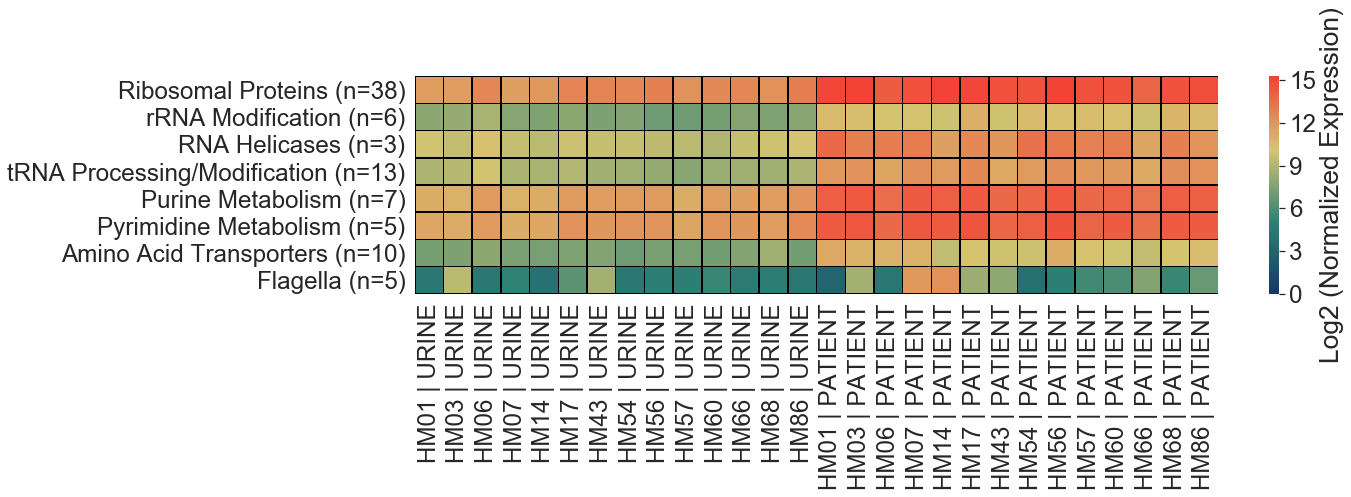

In [33]:
sns.set_style("white")
sns.set_context("notebook", font_scale=2.2)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(up_summary_no_LFC+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Expression)'})
fig.savefig(figs/"Figure_3b_i.png", dpi=150, bbox_inches="tight")

In [34]:
cnts_down = pd.concat(down_subsets.values(), axis=0, keys=down_subsets.keys(), names = ["Function", "Entry"],sort=False)
cnts_down = cnts_down.join(deseq2_counts, how='inner')
cnts_down.head()
down_summary = cnts_down.groupby(level=(0), sort=False).agg(['mean'])
down_summary_no_LFC = down_summary.iloc[:, 1:]
down_summary_no_LFC.columns = down_summary_no_LFC.columns.droplevel(level=1)
labels = []
sizes = cnts_down.groupby(level=0, sort=False).size()
for i,size in enumerate(sizes):
    labels.append("{} (n={})".format(sizes.index[i], size))
labels
down_summary_no_LFC.index = labels
down_summary_no_LFC

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Arginine Metabolism (n=10),4200.011906,3610.325569,4656.082387,1898.016133,5833.910586,3476.019080,3093.941386,6488.556284,5948.901204,2530.295692,...,993.436266,673.065612,687.022241,349.522215,401.809715,291.023287,341.279580,443.230955,471.748126,857.125964
Val/Leu/Ileu Metabolism (n=15),1329.343109,4246.974547,5306.946959,3992.126219,987.619890,14644.095311,1855.583241,2054.275157,11662.931415,1315.773465,...,233.843585,352.926013,510.206150,270.870899,281.015607,221.050475,152.388597,386.406474,218.625912,442.903735
Cys/Met Metabolism (n=8),8609.991309,10385.611690,16605.010303,5528.068682,22737.075653,35242.201788,28647.029016,26208.866650,33523.535724,41633.705758,...,1914.881847,981.661302,1848.524428,835.155881,615.374744,518.832499,534.246071,926.949354,885.367743,1184.388759
Gly/Ser/Thr Metabolism (n=8),4318.015800,4642.332871,4666.721501,3618.912475,5631.830345,7124.514266,5650.236769,6712.369086,6507.435624,6509.362436,...,1227.185976,617.963836,986.312988,822.370633,669.331188,486.032744,463.810644,628.620826,643.445627,1027.683052
Maltose Metabolism (n=5),5324.173739,796.825820,3621.996581,473.107327,3696.273385,158.762940,899.004882,5103.691789,1726.921931,1876.972395,...,14.222121,38.107770,518.381482,29.861636,50.399538,98.598053,82.927748,221.615478,36.960323,46.724472
Galactose Metabolism (n=21),3539.606926,2537.701996,2052.653216,1673.821783,2415.196874,1844.684573,953.508612,2480.936157,2217.019986,1303.301802,...,76.575493,147.624694,218.258019,171.141770,147.788120,138.203877,120.999584,182.650119,98.240859,156.599322
Starch/Sucrose Metabolism (n=8),1428.711565,1453.410554,1278.396291,1622.865034,1364.820286,1644.987797,1422.012581,1433.443943,1736.810648,2077.076477,...,175.576307,122.305343,418.168257,163.122123,192.238669,178.907758,151.502617,351.601479,120.121051,223.728515
Sugar Transporters (n=16),4734.733480,2619.020886,2719.784373,2759.787146,3928.416721,1096.916697,919.145967,4050.790056,1658.219442,2324.702847,...,177.116450,146.122699,499.717198,121.533330,170.949989,226.616494,214.628708,351.601479,159.601396,244.393881
Biofilm/Curli (n=10),1457.243937,702.843893,503.644984,842.025752,871.359867,294.819426,733.814139,583.951259,683.033785,447.851992,...,15.911878,20.083825,140.975433,13.284901,27.249511,27.830096,24.453054,51.142033,35.616311,239.239508


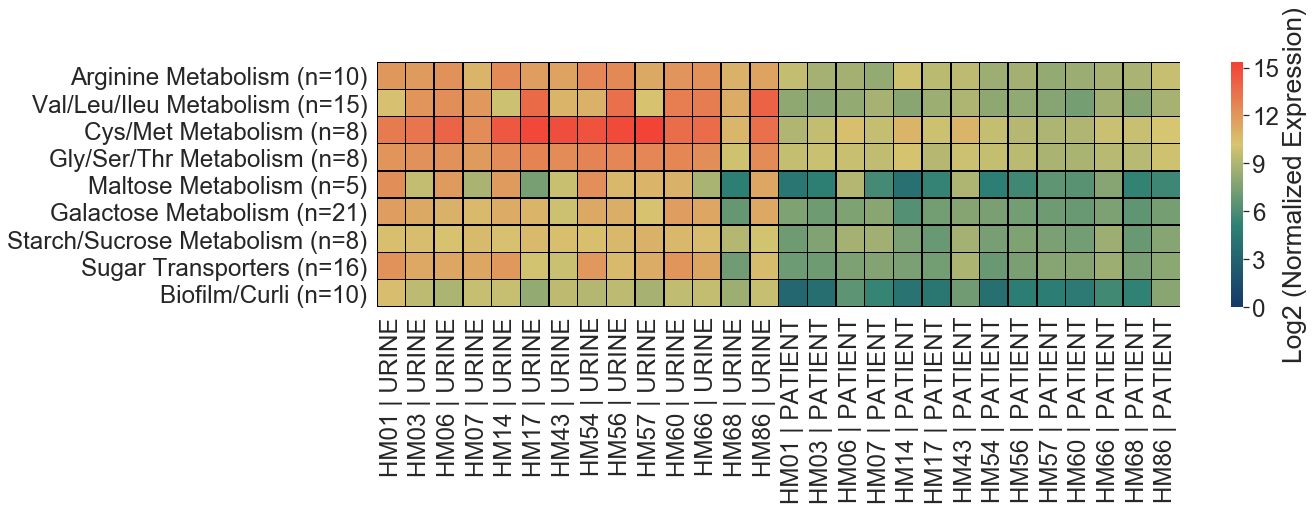

In [35]:
sns.set_style("white")
sns.set_context("notebook", font_scale=2.2)
fig = plt.figure(figsize=(18,4.5))
sns.heatmap(np.log2(down_summary_no_LFC+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Expression)'})
fig.savefig(figs/"Figure_3b_ii.png", dpi=150, bbox_inches="tight")

# Figure S7.

### Gene expression of four sugar transporters upregulated in UTI patients.  
Heatmap shows Log2 of normalized gene expression of *ptsG*, *fruA*, *fruB* and *gntU* for each in vitro and patient sample.

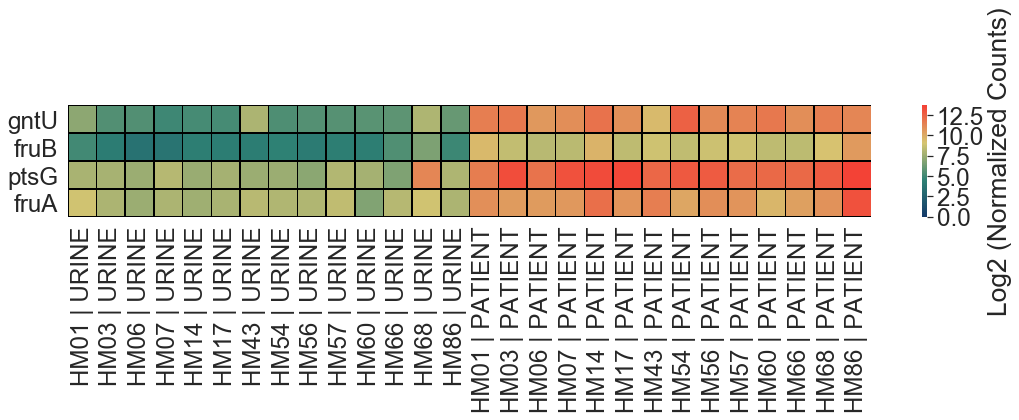

In [36]:
carbs_up = carb_transport_up.join(deseq2_counts, how="inner")
carbs_up_summary = carbs_up.groupby("Entry", sort=False).agg('mean').iloc[:,1:]
carbs_up_summary
labels = [carbs_up.loc[i]["Name"] for i in carbs_up.index]
carbs_up_summary.index = labels
fig = plt.figure(figsize=(18,2.05))
sns.heatmap(np.log2(carbs_up_summary+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})

fig.savefig(figs/"Figure_S7.png", dpi=150, bbox_inches="tight")

# Figure 4 and 5

### Fig. 4. UPEC optimize growth potential via resource reallocation during UTI. 

**(A)** Percentage of reads that aligned to the core genome (2653 genes) out of total mapped reads. 

**(B)** Percentage of core genome reads that mapped to R-proteins (ribosomal subunit proteins,  48 genes). 

**(C)** Percentage of core genome reads that mapped to catabolic genes (defined as genes regulated by Crp and present in the core genome (277 genes). 

**(D)** Percentage of core genome reads that mapped to amino acid biosynthesis genes (54 genes)

In [40]:
rprotein = get_subset_genes(de_results,"ribosomal subunit protein" ).index
anabolic_genes = ''
cnts_sum = raw_counts.sum() # counts dedicated to core genome expression
ribosome_sum= raw_counts.loc[rprotein].sum()
#ribosome_sum = ribosome_counts.sum()
crp_in_core = set(crp_genes).intersection(set(raw_counts.index))
crp_sum = raw_counts.loc[crp_in_core].sum()

In [41]:
from Bio.KEGG import REST

paths = ["path:eco00010", "path:eco00020"]

def get_genes_for_pathway(pathway):
    genes = []
    pathway_file = REST.kegg_get(pathway).read()
    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            gene_identifiers = line[12:].split("; ")[0]
            gene_id, gene_symbol = gene_identifiers.split()
            if not gene_symbol in genes:
                genes.append(gene_id)
    return genes
aa_biosynthesis = "eco00290,eco00300,eco00220,eco00400".split(",")

aa_A_genes = []
for p in aa_biosynthesis:
    aa_A_genes+= get_genes_for_pathway(p)
    
aa_A_genes_counts = raw_counts.loc[[g for g in aa_A_genes if g in raw_counts.index]].sum()

In [42]:
totals =  pd.DataFrame({'Core': cnts_sum,'R-protein':ribosome_sum, 'Catabolic genes': crp_sum,
                       'AA_genes':aa_A_genes_counts})
totals["C%"] = round(totals["Catabolic genes"]/totals["Core"]*100,2)
totals["R%"] = round(totals["R-protein"]/totals["Core"]*100,2)
totals["A%"] = round(totals["AA_genes"]/totals["Core"]*100,2)
totals['Sample'] = [ur  if 'UR' in c else uti for c in totals.index]
totals['Mapped'] = alingment_stats["Mapped Reads"]
totals["% core"] = round(totals["Core"]/totals["Mapped"]*100,2)
totals

,Core,R-protein,Catabolic genes,AA_genes,C%,R%,A%,Sample,Mapped,% core
HM01_UR,8339516.0,364511.0,2229966.0,314399.0,26.74,4.37,3.77,URINE,16480326,50.60
HM01_UTI,2270040.0,605552.0,260645.0,27217.0,11.48,26.68,1.20,PATIENT,3717040,61.07
HM03_UR,11344027.0,523235.0,2561484.0,591957.0,22.58,4.61,5.22,URINE,20927541,54.21
HM03_UTI,4913506.0,1397637.0,643289.0,46823.0,13.09,28.44,0.95,PATIENT,8059076,60.97
HM06_UR,11789016.0,883421.0,2478077.0,730018.0,21.02,7.49,6.19,URINE,22847374,51.60
HM06_UTI,2606614.0,506208.0,303138.0,37252.0,11.63,19.42,1.43,PATIENT,4709092,55.35
HM07_UR,10917809.0,480849.0,2156924.0,475423.0,19.76,4.40,4.35,URINE,20980473,52.04
HM07_UTI,1136237.0,253247.0,132565.0,13003.0,11.67,22.29,1.14,PATIENT,2097350,54.17
HM14_UR,11278572.0,512872.0,2786211.0,438807.0,24.70,4.55,3.89,URINE,21533817,52.38
HM14_UTI,7774529.0,2139952.0,1071556.0,86433.0,13.78,27.53,1.11,PATIENT,12968218,59.95


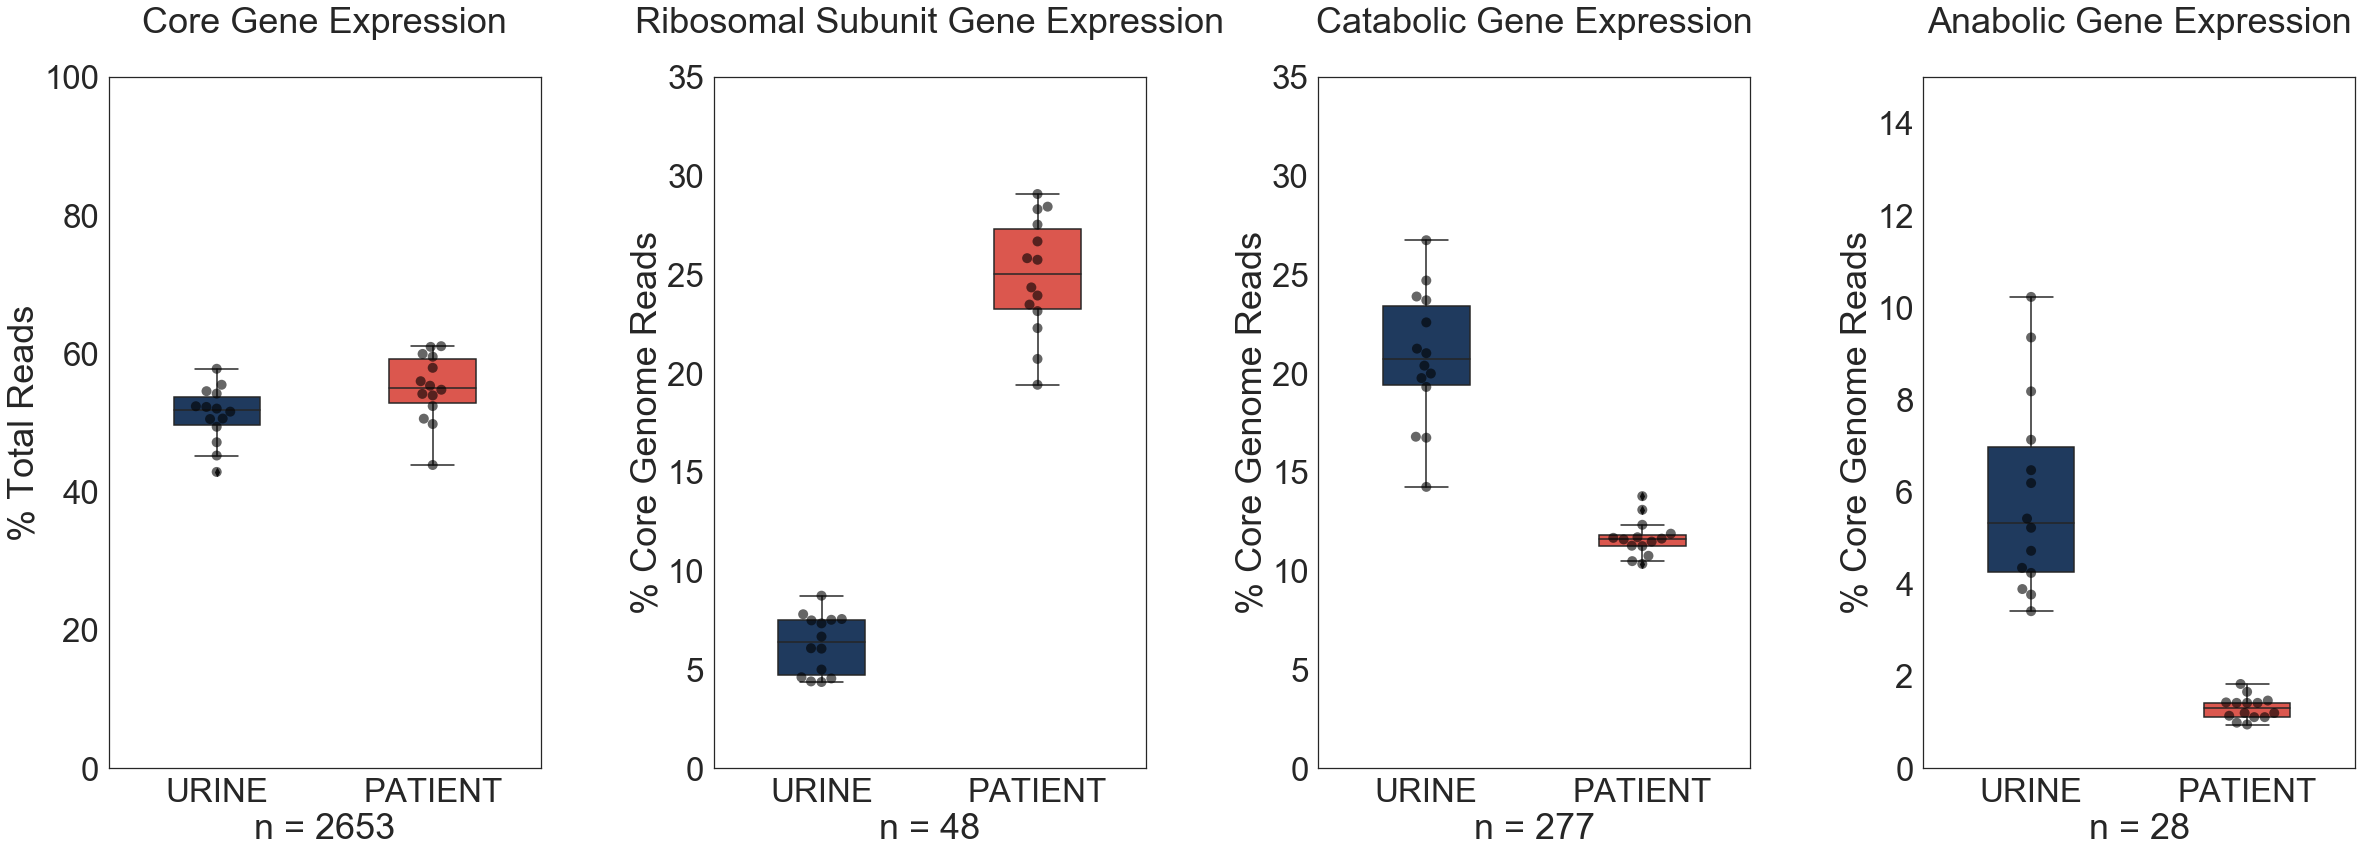

In [43]:
fig = plt.figure(figsize=(12,8))

sns.set(font_scale = 3)
sns.set_style("white")
# Core Gene Expression
ax1 = fig.add_axes([0.1, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 100))
#sns.violinplot(x = "Sample", y = "% core", palette=[col5, col1],data = totals,width=0.4)
sns.boxplot(x = "Sample", y = "% core", palette=[col5, col1],data = totals,width=0.4)
sns.swarmplot(x = "Sample", y = "% core", data = totals, color = 'black', alpha = 0.6, s=10)
ax1.set_title("Core Gene Expression\n")
ax1.set_xticklabels([ur, uti])
ax1.set_xlabel("n = {}".format(raw_counts.shape[0]))
ax1.set_ylabel("% Total Reads")

# Ribosome Subunits Gene Expression

ax2 = fig.add_axes([0.8, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))
#sns.violinplot(x = "Sample", y = "R%",palette=[col5, col1], data = totals, width=0.4)
sns.boxplot(x = "Sample", y = "R%",palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "R%", data =totals, color = 'black', alpha = 0.6, s=10)
ax2.set_title("Ribosomal Subunit Gene Expression\n")
ax2.set_xticklabels([ur, uti])
ax2.set_xlabel("n = {}".format(len(rprotein)))
ax2.set_ylabel("% Core Genome Reads")

# Catabolic Gene Expression

ax3 = fig.add_axes([1.5, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))
#sns.violinplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.boxplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "C%", data =totals, color = 'black', alpha = 0.6,s=10)
ax3.set_title("Catabolic Gene Expression\n")
ax3.set_xticklabels([ur, uti])
ax3.set_xlabel("n = {}".format(len(crp_in_core)))
ax3.set_ylabel("% Core Genome Reads")

ax4 = fig.add_axes([2.2, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 15))
sns.boxplot(x = "Sample", y = "A%", palette=[col5, col1], data = totals, width=0.4)
#sns.boxplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "A%", data =totals, color = 'black', alpha = 0.6,s=10)
ax4.set_title("Anabolic Gene Expression\n")
ax4.set_xticklabels([ur, uti])
ax4.set_xlabel("n = {}".format(aa_A_genes_counts.shape[0]))
ax4.set_ylabel("% Core Genome Reads")
fig.savefig(figs/"Figure_4.png",bbox_inches='tight',dpi=150 )

### Figure 5. Increased expression of ribosomal subunit transcripts is a host specific response.

**(A)** OD curve for HM43 strain cultured in LB and filter-sterilized urine. 

**(B)** Percentage of HM43 core genome reads that mapped to ribosomal subunit proteins under different conditions (URINE: in vitro culture in filter-sterilized urine, LB: in vitro culture in LB, MOUSE: mice with UTI, PATIENT: human UTI. 

**(C)** Percentage of HM43 core genome reads that mapped to catabolic genes under different conditions. 

In [44]:
mcnts = orth_matrix[["HM43"]].merge(mouse_counts, how='left', left_on='HM43', right_index=True).drop('HM43', axis=1)
mcore_cnts = mcnts.sum() # counts dedicated to core genome expression
mribosome_counts = mcnts.loc[rprotein]
mribosome_sum = mribosome_counts.sum()
mcrp_counts = mcnts.loc[crp_in_core]
mcrp_sum = mcrp_counts.sum()

hm43_alingment_stats.index = [i.split("_trimmed")[0] for i in hm43_alingment_stats.index]
mtotals =  pd.DataFrame({'Core': mcore_cnts,'R-protein':mribosome_sum, 'Catabolic genes': mcrp_sum})
mtotals["C%"] = round(mtotals["Catabolic genes"]/mtotals["Core"]*100,2)
mtotals["R%"] = round(mtotals["R-protein"]/mtotals["Core"]*100,2)
mtotals['Sample'] = [c.split("_")[1] for c in mtotals.index]
mtotals['%Core'] = mtotals["Core"]/hm43_alingment_stats['Mapped']*100
mtotals.at['HM43_UTI', '%Core'] =  56.0
R_sorted = mtotals.sort_values('R%')
R_sorted

,Core,R-protein,Catabolic genes,C%,R%,Sample,%Core
HM43_UR_rep2,15844775,388288,3551936,22.42,2.45,UR,36.768074
HM43_UR_rep1,17810139,707337,3586737,20.14,3.97,UR,42.111310
HM43_LB_rep1,33719081,4408563,6795490,20.15,13.07,LB,53.680883
HM43_LB_rep2,19510801,2552136,3857542,19.77,13.08,LB,52.602715
HM43_mouse,2022208,429120,285538,14.12,21.22,mouse,54.799801
HM43_UTI,4557691,1091252,562077,12.33,23.94,UTI,56.000000


(0, 100)

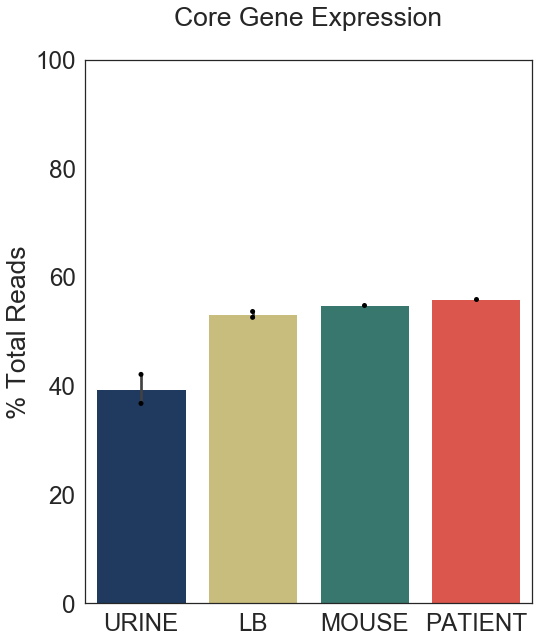

In [45]:
sns.set(font_scale = 2.2)
sns.set_style("white")
f = plt.figure(figsize=(8,10));
ax = sns.barplot(x="Sample", y="%Core", data=R_sorted, palette=[col5, col2, col4, col1]);
sns.swarmplot(x = "Sample", y = "%Core", data = R_sorted, color = 'black');
ax.set_xticklabels(["URINE", "LB", "MOUSE", "PATIENT"]);
ax.set_ylabel("% Total Reads");
ax.set_title("Core Gene Expression\n");
ax.set_xlabel("");
ax.set_ylim((0,100))


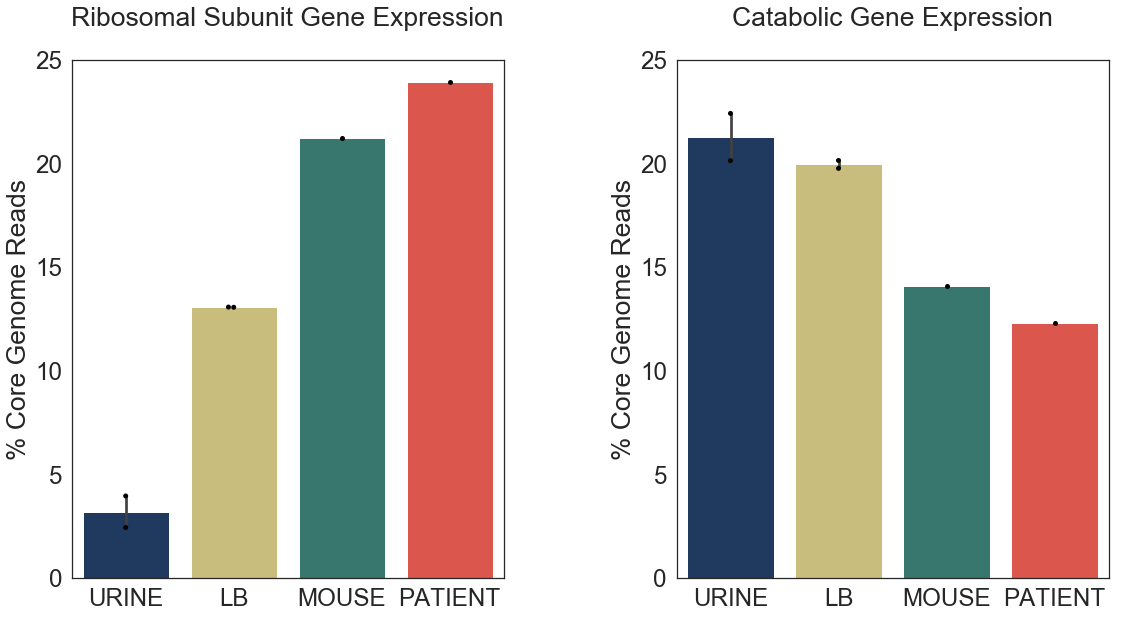

In [46]:
fig = plt.figure(figsize=(12,6))

sns.set(font_scale = 2.2)
sns.set_style("white")

ax1 = fig.add_axes([0.1, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 100))

sns.barplot(x="Sample", y="R%", data=R_sorted, palette=[col5, col2, col4, col1]);
sns.swarmplot(x = "Sample", y = "R%", data = R_sorted, color = 'black');
ax1.set_xticklabels(["URINE", "LB", "MOUSE", "PATIENT"]);
ax1.set_ylabel("% Core Genome Reads");
ax1.set_title("Ribosomal Subunit Gene Expression\n");
ax1.set_xlabel("");
ax1.set_ylim((0,25))

ax2 = fig.add_axes([0.8, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))

sns.barplot(x="Sample", y="C%", data=R_sorted, palette=[col5, col2, col4, col1]);
sns.swarmplot(x = "Sample", y = "C%", data = R_sorted, color = 'black');
ax2.set_xticklabels(["URINE", "LB", "MOUSE", "PATIENT"]);
ax2.set_ylabel("% Core Genome Reads");
ax2.set_title("Catabolic Gene Expression\n");
ax2.set_xlabel("");
ax2.set_ylim((0,25));

fig.savefig(figs/"Figure_5bc.png",bbox_inches='tight',dpi=150 )

#### Growth Rate estimation

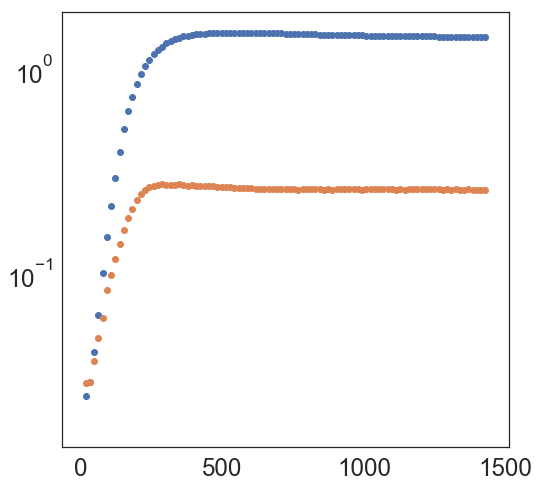

In [47]:
growth_data["LB_av"] = growth_data[[c for c in growth_data.columns if 'LB' in c]].mean(axis=1)
growth_data['UR_av'] = growth_data[[c for c in growth_data.columns if 'Urine' in c]].mean(axis=1)
growth_data['minutes'] = pd.to_timedelta(growth_data.time).dt.total_seconds()/60
dt_df = growth_data[['minutes', 'LB_av', 'UR_av']]
plt.figure(figsize=(8,8))
plt.scatter(dt_df.minutes, dt_df.LB_av,  )
plt.scatter(dt_df.minutes, dt_df.UR_av,  )
plt.yscale("log")

In [48]:
def calc_dt(c1, c2, duration):
    return (duration*np.log(2))/(np.log(c2) - np.log(c1))

df = dt_df[(dt_df.minutes < 190) &(dt_df.minutes > 30) ].reset_index()


LB_dts= []
UR_dts= []
for points in itertools.combinations(df.index, 2):
    t1 = min(points)
    t2 = max(points)
    lb1 = df.iloc[t1]['LB_av']
    lb2 = df.iloc[t2]['LB_av']
    u1 = df.iloc[t1]['UR_av']
    u2 = df.iloc[t2]['UR_av']
    duration = df.iloc[t2]['minutes'] - df.iloc[t1]['minutes']
    LB_dts.append(calc_dt(lb1, lb2, duration))
    UR_dts.append(calc_dt(u1, u2, duration))
    
print("LB Mean")
print(pd.Series(LB_dts).mean())
print('LB Median')
print(pd.Series(LB_dts).median())

print('Urine Mean')
print(pd.Series(UR_dts).mean())
print('Urine Median')
print(pd.Series(UR_dts).median())

LB Mean
33.022816004
LB Median
30.6624746767
Urine Mean
54.9181596077
Urine Median
52.4547056258


# Figure 6 

### Differential regulon expression suggests role for multiple regulators in resource reallocation. 

Regulon expression for 8 out of 22 regulons enriched for genes downregulated in the patients. Expression of each gene in the regulon during in vitro culture (blue) or during UTI (red) is shown along the x-axis. Histograms show proportion of genes in the regulon expressed at any given level.

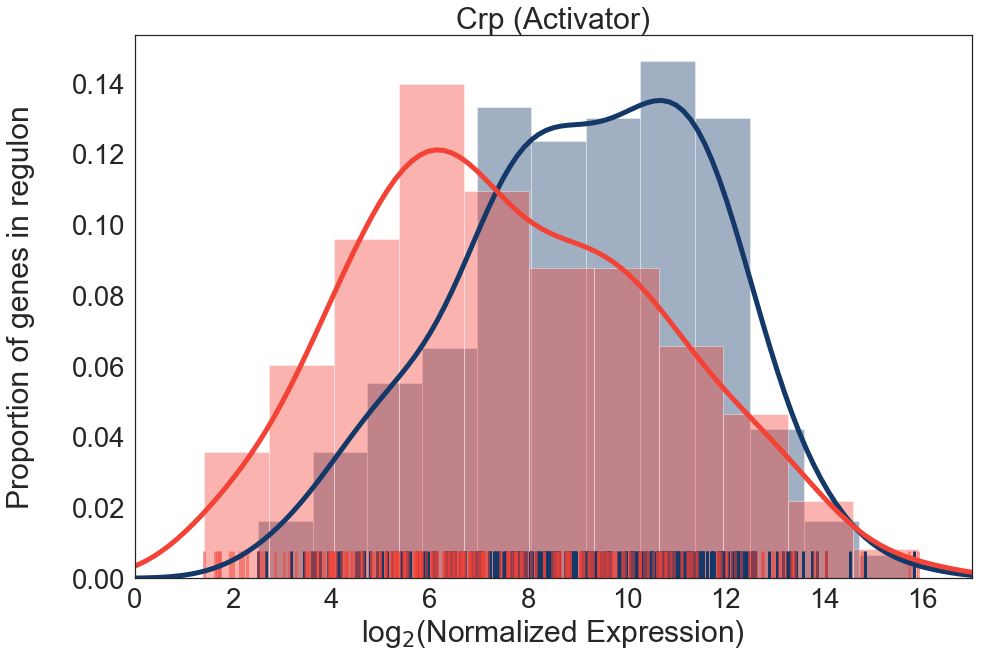

In [49]:
def plot_regulon_hist(regulator, function, ga, df_cnts, genes=""):
    if not genes:
        genes = ga[ga.Function==function].loc[regulator].Genes.split(",")
    df_ur = df_cnts[[c for c in df_cnts.columns if 'UR' in c]]
    df_uti = df_cnts[[c for c in df_cnts.columns if 'UTI' in c]]
    title = regulator + " ({})".format(function)
    urine = np.log2(df_ur.loc[genes]+1).mean(axis=1)
    patient = np.log2(df_uti.loc[genes]+1).mean(axis=1)
    sns.distplot(urine, color=col5, kde_kws={'linewidth':5})
    sns.rugplot(urine, color=col5,linewidth=3)
    sns.distplot(patient, color=col1, kde_kws={'linewidth':5})
    ax = sns.rugplot(patient, color=col1,alpha=0.5, linewidth=3)
    plt.ylabel("Proportion of genes in regulon\n")
    plt.xlabel('log$_2$(Normalized Expression)')
    plt.title(title)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

sns.set(font_scale = 2.5)
sns.set_style("white")
fig = plt.figure(figsize=(15,10))
plt.xlim(0,17)
plot_regulon_hist('Crp', 'Activator', gsea_analysis, deseq2_counts)

In [50]:
lrp_genes = set([ gene for g in gsea_analysis.loc['Lrp'].Genes.values for gene in g.split(",")])
urine_high = [('Crp', 'Activator'), ('Lrp', 'Dual', lrp_genes), ('NarL', 'Repressor'), ('MetJ', 'Repressor'),
              ('CsgD', 'Activator'), ('ModE', 'Activator'), ('GadX', 'Activator'), ('YdeO', 'Activator'), ]

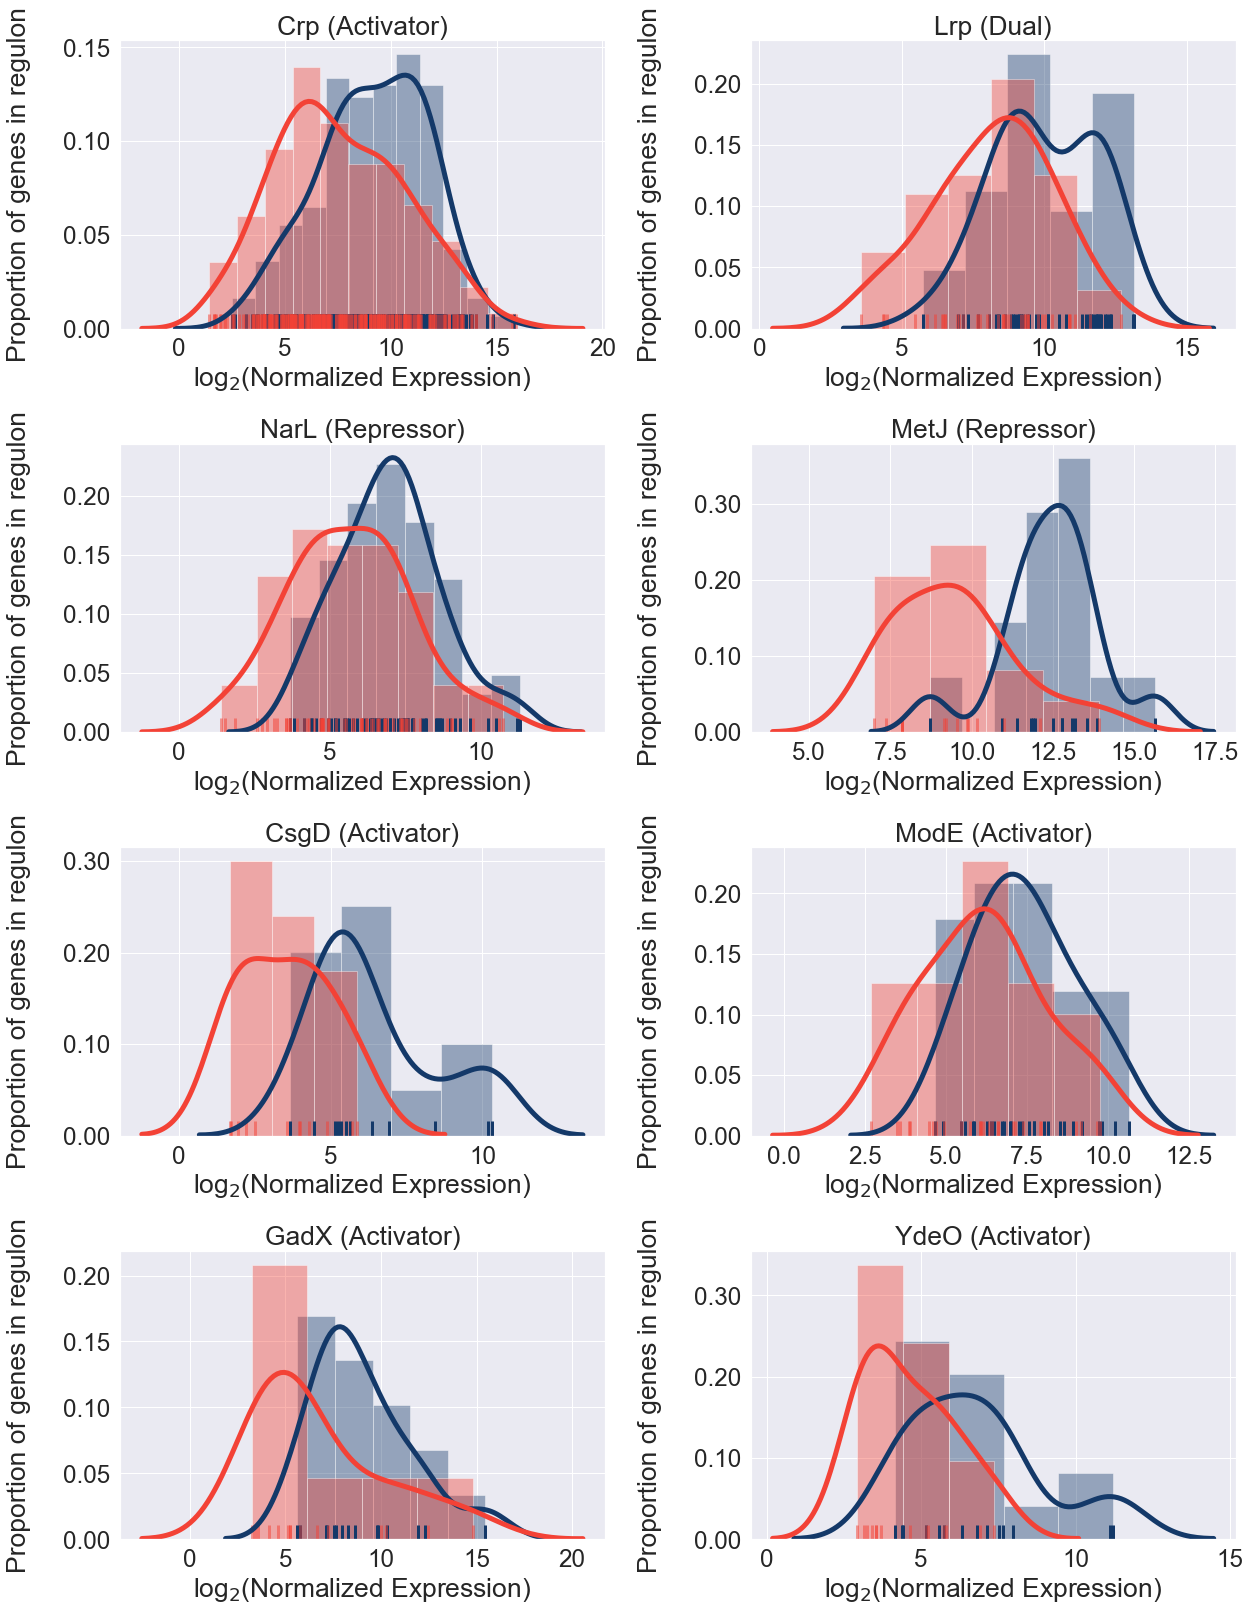

In [51]:
sns.set(font_scale = 2.2)
fig = plt.figure(figsize=(20, 35))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
for i, s  in enumerate(urine_high):  
    ax = fig.add_subplot(5, 2, i+1)
    if len(s) != 2:
        plot_regulon_hist(s[0], s[1], gsea_analysis, deseq2_counts, genes=s[2])
    else:
        plot_regulon_hist(s[0],s[1], gsea_analysis, deseq2_counts)

fig.savefig(figs/"Figure_6.png", dpi=150, bbox_inches="tight")

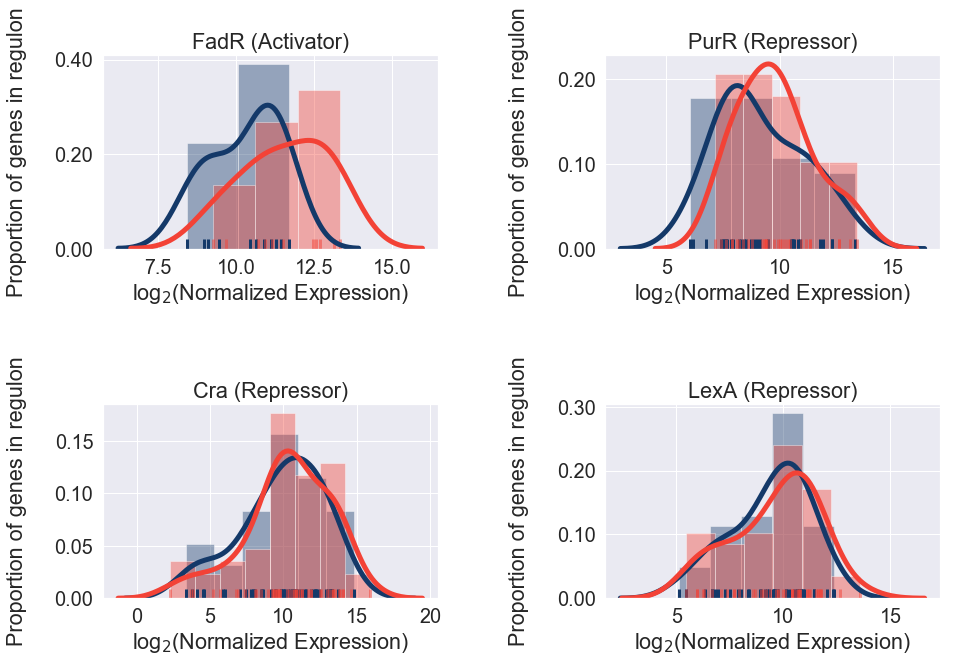

In [52]:
sns.set(font_scale = 1.8)

under = gsea_analysis[gsea_analysis.NES<0]
patient_high = [(i, f) for i, f in zip(under.index, under.Function)]
patient_high
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.8, wspace=0.5)
for i, s  in enumerate(patient_high):  
    ax = fig.add_subplot(2, 2, i+1)
    plot_regulon_hist(s[0], s[1], gsea_analysis, deseq2_counts)

In [53]:
all_regulon_genes = set([gene for g in gsea_analysis.Genes.values for gene in g.split(",")])
print("Number of genes in all the regulons: {}".format(len(all_regulon_genes)))
urine_high_genes = set([gene for g in gsea_analysis[gsea_analysis.NES>0].Genes.values for gene in g.split(',')])
print("Number of genes in Urine HIGH regulons: {}".format(len(urine_high_genes)))
patient_high_genes = set([gene for g in gsea_analysis[gsea_analysis.NES<0].Genes.values for gene in g.split(',')])
print("Number of genes in Patient HIGH regulons: {}".format(len(patient_high_genes)))
print("Number of genes in both: {}".format(len(patient_high_genes)+len(urine_high_genes)-len(all_regulon_genes)))

Number of genes in all the regulons: 637
Number of genes in Urine HIGH regulons: 549
Number of genes in Patient HIGH regulons: 135
Number of genes in both: 47


In [54]:
de_genes = set(de_sign.index)
print("Number of differentially expressed genes: {}".format(len(de_genes)))
r = de_genes.intersection(all_regulon_genes)
pcnt_explained = len(r)/len(de_genes)*100
print("Percent differentially expressed genes in all regulons: {}%".format(round(pcnt_explained, 1)))

de_genes_down = set(de_sign[de_sign.log2FoldChange < 0].index)
r = de_genes_down.intersection(urine_high_genes)
pcnt_explained = len(r)/len(de_genes_down)*100
print("Percent downregulated genes in Urine-high regulons: {}%".format(round(pcnt_explained, 1)))


de_genes_up = set(de_sign[de_sign.log2FoldChange > 0].index)
r = de_genes_up.intersection(patient_high_genes)
pcnt_explained = len(r)/len(de_genes_up)*100
print("Percent upregulated genes in Patient-high regulons: {}%".format(round(pcnt_explained, 1)))

Number of differentially expressed genes: 494
Percent differentially expressed genes in all regulons: 39.3%
Percent downregulated genes in Urine-high regulons: 50.3%
Percent upregulated genes in Patient-high regulons: 6.0%
